## Developing KNN code

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.neighbors import KNeighborsClassifier
# from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image
from utils.analysis import knn
from parse_config import ConfigParser
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor
from utils import prepare_device, copy_file, read_lists #, show_image
# from utils.visualizations import show_image
# sys.path.insert(0, os.path.join('external_code', 'EditingClassifiers'))
# from helpers.context_helpers import fea

In [3]:
# Define constants, paths
config_path = 'configs/debug/cinic10_imagenet_edit_debug.json'
anchor_image1_path = 'data/editing/dummy/tank1.jpg'
anchor_image2_path = 'data/editing/dummy/tank1.jpg'

edited_model_path = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1209_134754/models/edited_model.pth'
IMAGE_SIZE = (32, 32)

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

In [4]:
# Load config file, models, and dataloader
config_json = read_json(config_path)
config = ConfigParser(config_json)
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Create original model, by default restores from path in config.arch.args.checkpoint_path
orig_model = config.init_obj('arch', module_arch, layernum=layernum)

# Restore edited model
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)

val_data_loader = config.init_obj('data_loader', module_data, split='valid')
test_data_loader = config.init_obj('data_loader', module_data, split='test')

# print(ckpt['arch'])
# layernum = config.config['layernum']
# orig_model = config.init_obj('arch', module_arch, layernum=layernum)
# print(orig_model.checkpoint_path)
# # orig_model.eval()
# edited_model = config.init_obj('arch', module_arch, layernum=layernum)
# edited_model.restore_model(restore_path=edited_model_path)
# print(config.config['data_loader'])
# val_data_loader = config.init_obj('data_loader', module_data, split='valid')
# test_data_loader = config.init_obj('data_loader', module_data, split='test')

In [ ]:
# If desired, can run both models on the test set for sanity checks


loss_fn = getattr(module_loss, config['loss'])
metric_fns = []
for met in config['metrics']:
    metric_fns.append(getattr(module_metric, met))

original_performance = predict(
    data_loader=test_data_loader,
    model=orig_model,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    device=device)
    
edited_performance = predict(
    data_loader=test_data_loader,
    model=edited_model,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    device=device)

print("Original model performance: {}".format(original_performance))
print("Edited model performance: {}".format(edited_performance))

### Perform KNN before and after the edit

In [5]:
# def load_two_way_dictionary(dictionary_path):
#     with open(dictionary_path, "r") as f:
#         key_to_val = json.load(f)
#     val_to_key = {}
#     for key, val in key_to_val.items():
#         val_to_key[val] = key
#     return key_to_val, val_to_key

In [5]:
# Load images as numpy arrays
anchor_image1 = load_image(anchor_image1_path, resize=IMAGE_SIZE)
anchor_image2 = load_image(anchor_image2_path, resize=IMAGE_SIZE)

# Stack along new dim to make 4D tensor
anchor_images = np.stack([anchor_image1, anchor_image2], axis=0)

# Load idx_to_word and word_to_idx dictionary for labels
# label_dictionary_path = "metadata/cinic-10/idx_class_dict.json"
# idx_label_dict, label_idx_dict = load_two_way_dictionary(label_dictionary_path)
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
# print(idx_label_dict, label_idx_dict)

In [7]:
# Perform KNN on original model

unedited_model_knn = knn(
    K=K,
    data_loader=val_data_loader,
    model=orig_model,
    anchor_image=anchor_images,
    data_types=knn_data_types,
    device=device)



100%|████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.23it/s]

(1000, 3072)
1000
(2, 3072)
indices shape: (2, 10)
image_paths len: 2 by 10
(1000, 512)
1000
(2, 512)
indices shape: (2, 10)
image_paths len: 2 by 10
(1000, 10)
1000
(2, 10)
indices shape: (2, 10)
image_paths len: 2 by 10


## Visualize!

In [19]:
def show_image_rows(images, 
                    image_titles=None, 
                    image_size=(2.5, 2.5),
                    row_labels=None,
                    figure_title=None, 
                    font_size=12,
                    save_path=None):
    """
    Display rows of images

    Arg(s):
        images : list[list[np.array]]
            2D array of images to display
        image_labels : list[list[str]] or None
            2D array of image labels, must be same shape as iamges
        image_size : (float, float)
            width, height of each image
        row_labels : list[str]
            list of labels for each row, must be same length as len(images)
        figure_title : str
            title for overall figure
        font_size : int
            font size
        save_path : str
            path to save figure to
    """

    n_rows, n_cols = len(images), len(images[0])
    # Shape sanity checks
    if image_titles is not None:
        assert len(image_titles) == n_rows
        assert len(image_titles[0]) == n_cols
    if row_labels is not None:
        assert len(row_labels) == n_rows
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(image_size[0] * n_cols, image_size[1] * n_rows))

    for row in range(n_rows):
        for col in range(n_cols):
            # Obtain correct axis
            ax = axs[row, col]
            
            # Display the image
            image = images[row][col]
            if image is None:
                continue
            print(type(image))
            if image.shape[0] == 3:
                image = torch.tensor(image)
                image = torch.permute(image, (1, 2, 0)) 
                # FOR SOME REASON I KEEP GETTING numpy has no attribute transpose
                # np.tranpose(image, (1, 2, 0))
                
            ax.imshow(image)
            
            # Display row text if first image in row
            if row_labels is not None and col == 0:
                ax.set_ylabel(row_labels[row], fontsize=font_size)
            # Display image title
            if image_titles is not None:
                ax.set_title(image_titles[row][col], fontsize=font_size)
    
    # Set figure title
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=font_size)
    
    # Save if path is provided
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

In [20]:
def make_grid(flattened, items_per_row):
    length = len(flattened)
    grid = []
    for i in range(0, length, items_per_row):
        if i + items_per_row <= length:
            grid.append(flattened[i: i + items_per_row])
        else:
            padded_row = flattened[i:]
            while len(padded_row) < items_per_row:
                padded_row.append(None)
            grid.append(padded_row)
    return grid

def display_nearest_neighbors(image_paths, 
                              labels, 
                              items_per_row=5,
                              image_size=(2.5, 2.5),
                              row_labels=None,
                              figure_title=None, 
                              font_size=12,
                              save_path=None):
    '''
    Show images of nearest neighbors
    
    Arg(s):
        image_paths : list[str]
            list of paths to images 
        labels : list[str]
            list of labels of images
        
    '''
    assert len(image_paths) == len(labels)
    
    images = []
    for image_path in image_paths:
        image = load_image(image_path)
        images.append(image)
    
    # Convert images and labels to grid
    images = make_grid(images, items_per_row)
    labels = make_grid(labels, items_per_row)
    
    show_image_rows(
        images=images,
        image_titles=labels,
        row_labels=row_labels,
        figure_title=figure_title,
        font_size=font_size,
        save_path=save_path)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


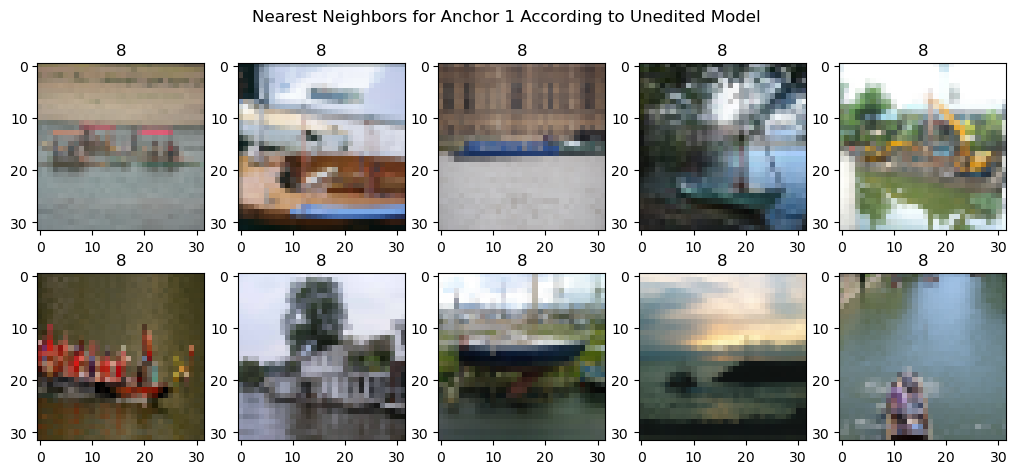

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


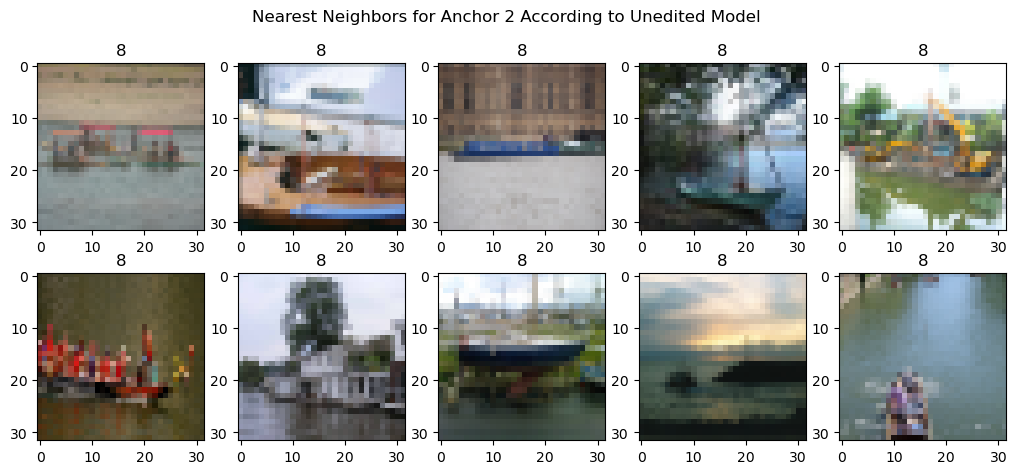

In [21]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
data_type = 'features'
unedited_results = unedited_model_knn[data_type]
# Keys: 'indices', 'distances', 'image_paths', 'labels'
anchor1_indices = unedited_results['indices'][0]
anchor1_distances = unedited_results['distances'][0]
anchor1_image_paths = unedited_results['image_paths'][0]
anchor1_labels = unedited_results['labels'][0]
anchor1_labels = [class_list[label] for label in anchor1_labels]

display_nearest_neighbors(
    image_paths=anchor1_image_paths,
    labels=anchor1_labels,
    figure_title='Nearest Neighbors for Anchor 1 According to Features of Unedited Model')

anchor2_indices = unedited_results['indices'][1]
anchor2_distances = unedited_results['distances'][1]
anchor2_image_paths = unedited_results['image_paths'][1]
anchor2_labels = unedited_results['labels'][1]
anchor2_labels = [class_list[label] for label in anchor2_labels]

display_nearest_neighbors(
    image_paths=anchor2_image_paths,
    labels=anchor2_labels,
    figure_title='Nearest Neighbors for Anchor 2 According to Features of Unedited Model')

<class 'str'>


AttributeError: 'str' object has no attribute 'shape'

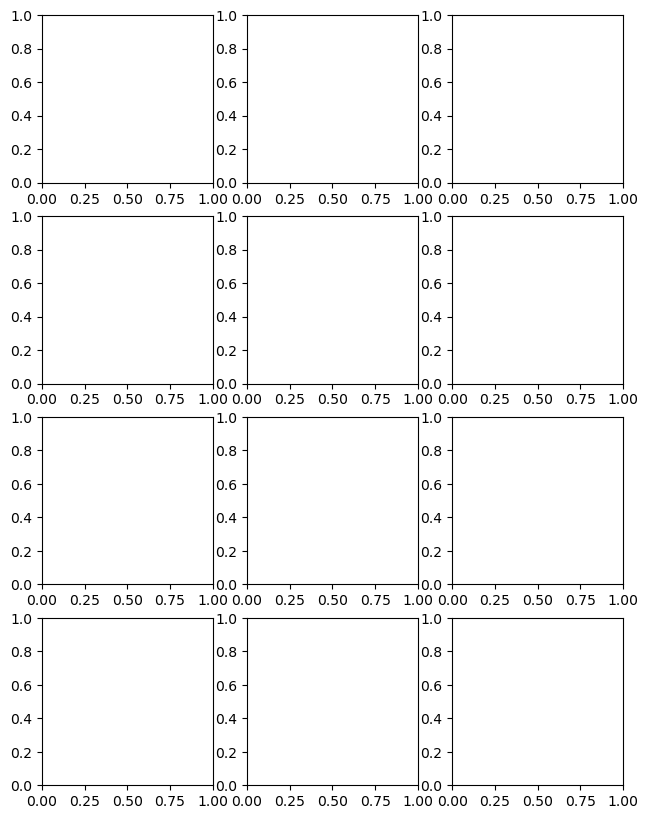

In [27]:
show_image_rows(
    images=images_grid,
    image_titles=labels_grid,
    image_size=(2.5, 2.5),
    font_size=12)

In [21]:
# Load base images and convert to tensor

base_image1 = load_image(base_image1_path, resize=IMAGE_SIZE)
base_image1 = torch.tensor(base_image1).type(torch.float32)
base_image2 = load_image(base_image2_path, resize=IMAGE_SIZE)
base_image2 = torch.tensor(base_image2).type(torch.float32)

torch.Size([3, 32, 32])


In [ ]:
# Perform KNN for images
data_type = 'images'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)

neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
print(neighbor_labels)
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)

In [ ]:
# Perform KNN for logits
data_type = 'images'
all_data, labels, image_paths, base_data = prepare_knn(
    data_loader=val_data_loader,
    model=model,
    base_image=base_image,
    data_type=data_type
)

distances, indices = knn(
    K=K,
    data=all_data,
    labels=labels,
    point=base_data)

neighbor_image_paths = [image_paths[idx] for idx in indices[0]]
neighbor_labels = [labels[idx] for idx in indices[0]]
print(neighbor_labels)
for path, label in zip(neighbor_image_paths, neighbor_labels):
    image = load_image(path)
    image = np.transpose(image, (1, 2, 0))
    show_image(image)
    print(label)